In [1]:
from ipfml import processing
from ipfml import utils
from ipfml import metrics
from PIL import Image
from scipy import signal
from skimage import color
import scipy.stats as stats
import seaborn as sns
import cv2
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import svd
import os

In [2]:
data_folder = "../fichiersSVD_light"

# SVD reconstruction analysis on Synthesis Images 

## Utils functions definition

In [3]:
def compute_images_path(dict_data):
    
    scene = dict_data['name']
    prefix = dict_data['prefix']
    indices = dict_data['indices']
    
    images_path = []
    for index in indices:
        path = os.path.join(data_folder, os.path.join(scene, prefix + index + ".png"))
        print(path)
        images_path.append(path)
    return images_path

In [4]:
def get_images_zones(dict_data, images_path):
    
    id_zone = dict_data['zone']
    
    zones_img = []
    for path in images_path:
        img = Image.open(path)
        zones = processing.divide_in_blocks(img, (200, 200))
        zones_img.append(zones[id_zone])
        
    return zones_img

In [5]:
def display_svd_reconstruction(interval, zones):
    
    output_images = []
    begin, end = interval
    for zone in zones:
        lab_img = metrics.get_LAB_L(zone)
        lab_img = np.array(lab_img, 'uint8')
        
        U, s, V = svd(lab_img, full_matrices=True)
        
        smat = np.zeros((end-begin, end-begin), dtype=complex)
        smat[:, :] = np.diag(s[begin:end])
        output_img = np.dot(U[:, begin:end],  np.dot(smat, V[begin:end, :]))
        
        print(np.allclose(lab_img, output_img))
        
        output_img = np.array(output_img, 'uint8')
        output_images.append(Image.fromarray(output_img))
        
    return output_images

In [17]:
def display_images(dict_data, rec_images):
    
    indices = dict_data['indices']
    scene = dict_data['name']
    
    fig=plt.figure(figsize=(15, 8))
    columns = len(zones)
    rows = 1
    for i in range(1, columns*rows +1):
        index = i - 1
        fig.add_subplot(rows, columns, i)
        plt.imshow(rec_images[index], label=scene + '_' + str(indices[index]))
        img_path = 'tmp_images/' + dict_data['prefix'] + 'zone'+ str(current_dict['zone']) + '_reconstruct_' + str(indices[index]) + '.png'
        Image.fromarray(np.asarray(rec_images[index], 'uint8')).save(img_path)
    plt.show()
    

In [7]:
def diff_between_images(noisy, ref):
    noisy = np.asarray(noisy)
    ref = np.asarray(ref)
    
    return ref - noisy

In [25]:
def display_sv_data(dict_data, zones_data, interval, reduced=True):
    
    scene_name = dict_data['name']
    image_indices = dict_data['indices']
    zone_indice = dict_data['zone']
    
    plt.figure(figsize=(25, 20))
    
    sv_data = []
    begin, end = interval
    for id_img, zone in enumerate(zones_data):
        zone = np.asarray(zone)
        print(zone.shape)
        U, s, V = metrics.get_SVD(zone)

        data = s[begin:end]
        
        label_plt = 'Zone ' + str(zone_indice)
        
        if reduced:
            label_plt += ' reduced info '
        
        label_plt += 'of ' + scene_name + '_' + str(image_indices[id_img])
        
        plt.plot(data, label=label_plt)
    
    plt.legend(fontsize=18)
    plt.show()

## Scenes information data

In [9]:
# start 00020 - ref 00900 - step 10
dict_appart = {'name': 'Appart1opt02', 
               'prefix': 'appartAopt_', 
               'indices': ["00100","00250","00400","00550"],
               'zone': 9}

# start 00050 - ref 01200 - step 10
dict_cuisine = {'name': 'Cuisine01', 
               'prefix': 'cuisine01_', 
               'indices': ["00050", "00400", "01200"],
               'zone': 3}

# start 00020 - ref 00950 - step 10
dict_sdb_c = {'name': 'SdbCentre', 
               'prefix': 'SdB2_', 
               'indices': ["00020", "00400", "00950"],
               'zone': 3}

# start 00020 - ref 00950 - step 10
dict_sdb_d = {'name': 'SdbDroite', 
               'prefix': 'SdB2_D_', 
               'indices': ["00020", "00400", "00950"],
               'zone': 3}

### Definition of parameters

Here we define parameters for the rest of this study :
- the scene used
- the reconstructed interval (give reduced information from SVD decomposition) 
- the displayed interval of SVD values

In [10]:
current_dict = dict_appart
displayed_interval = (50, 200)
reconstructed_interval = (90, 200)

In [11]:
images_path = compute_images_path(current_dict)

../fichiersSVD_light/Appart1opt02/appartAopt_00100.png
../fichiersSVD_light/Appart1opt02/appartAopt_00250.png
../fichiersSVD_light/Appart1opt02/appartAopt_00400.png
../fichiersSVD_light/Appart1opt02/appartAopt_00550.png


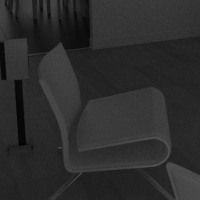

In [18]:
zones = get_images_zones(current_dict, images_path)

# save each zone
for id, zone in enumerate(zones):
    img_name = current_dict['prefix'] + 'zone'+ str(current_dict['zone']) + '_' + current_dict['indices'][id] + '.png'
    zone.save('tmp_images/' + img_name)

Image.fromarray(np.array(metrics.get_LAB_L(zones[0]), 'uint8'))

In [20]:
reconstructed_images = display_svd_reconstruction(reconstructed_interval, zones)

False
False
False
False


/home/jbuisine/.pyenv/versions/thesis-venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


Overview information for each images (with samples : \["00200","00250","00300","00350"\]) reconstructed with reduced information. Images are displayed following this samples list from left to right.

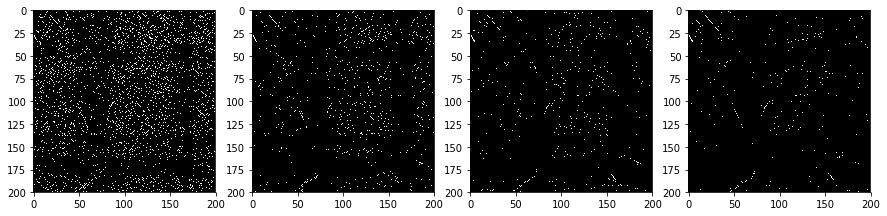

In [21]:
display_images(current_dict, reconstructed_images)

## Display of SV values obtained to compare

### With reduction of reconstructed images

(200, 200)
(200, 200)
(200, 200)
(200, 200)


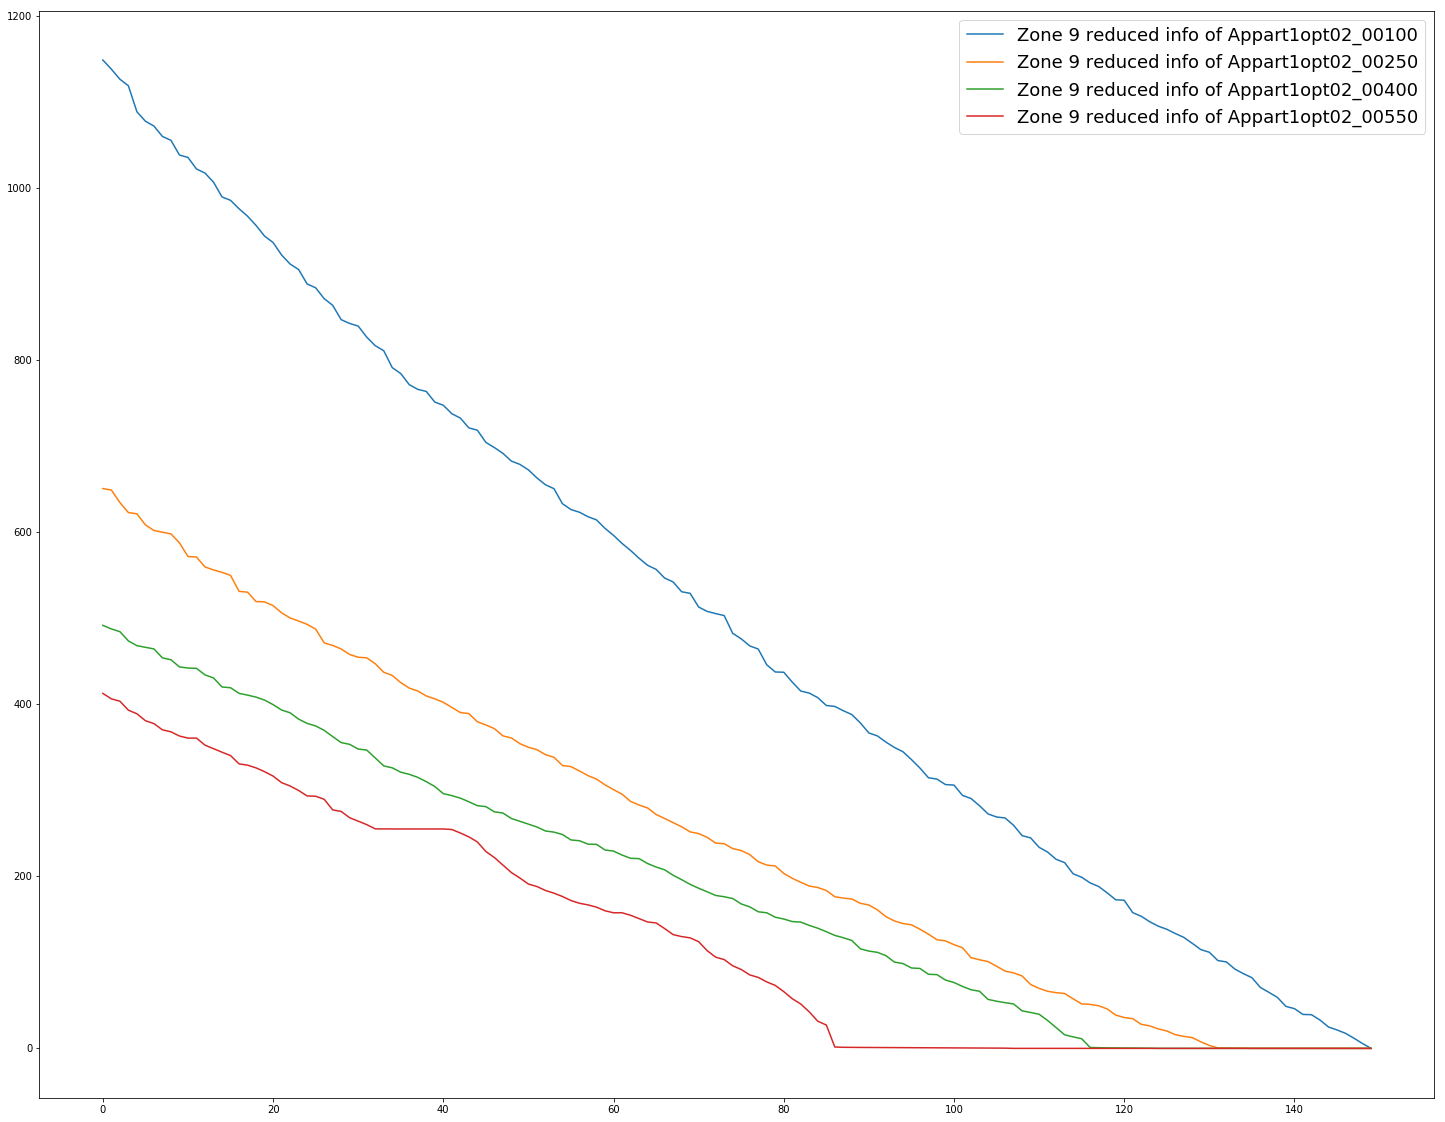

In [26]:
display_sv_data(current_dict, reconstructed_images, displayed_interval)

### Without reduction of information

(200, 200)
(200, 200)
(200, 200)
(200, 200)


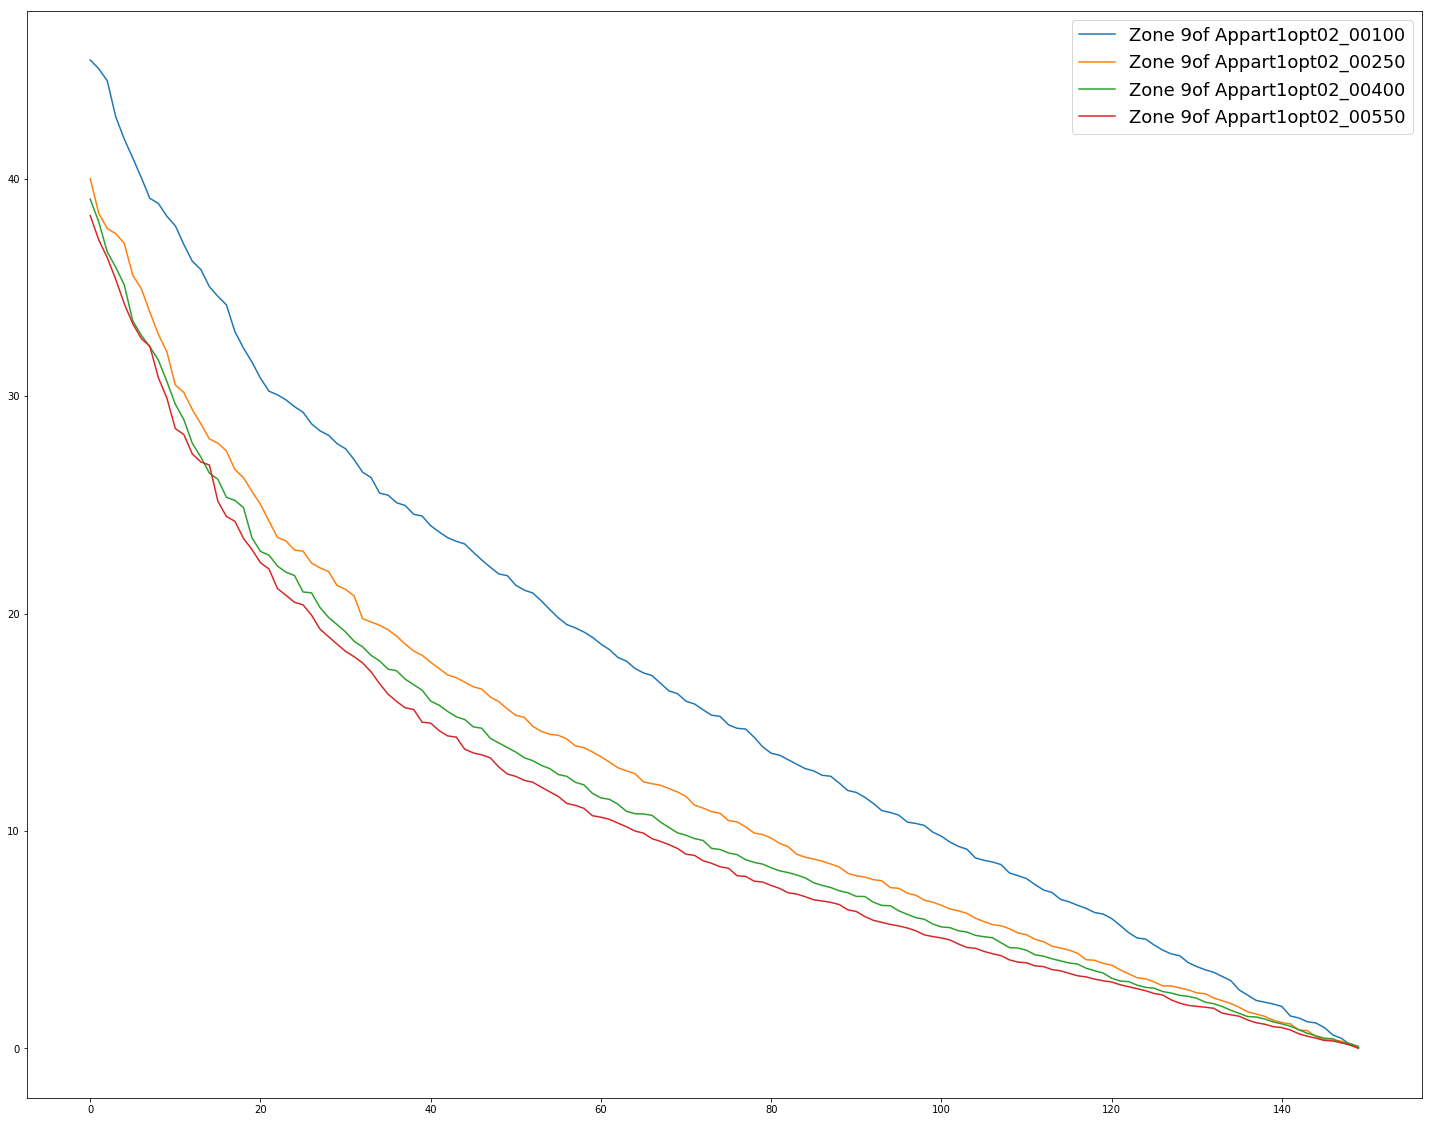

In [27]:
zones_lab = [Image.fromarray(np.array(metrics.get_LAB_L(z), 'uint8')) for z in zones]
display_sv_data(current_dict, zones_lab, displayed_interval, reduced=False)

## Noise mask analysis
Next part to explore (extraction of noise filter)..

In [310]:
# start 00020 - ref 00900 - step 10
dict_appart = {'name': 'Appart1opt02', 
               'prefix': 'appartAopt_', 
               'indices': ["00020", "00900"],
               'zone': 3}

# start 00050 - ref 01200 - step 10
dict_cuisine = {'name': 'Cuisine01', 
               'prefix': 'cuisine01_', 
               'indices': ["00050", "00400", "01200"],
               'zone': 3}

# start 00020 - ref 00950 - step 10
dict_sdb_c = {'name': 'SdbCentre', 
               'prefix': 'SdB2_', 
               'indices': ["00020", "00400", "00950"],
               'zone': 3}

# start 00020 - ref 00950 - step 10
dict_sdb_d = {'name': 'SdbDroite', 
               'prefix': 'SdB2_D_', 
               'indices': ["00020", "00400", "00950"],
               'zone': 3}

In [311]:
mask_current_dict = dict_appart

In [312]:
mask_images_path = compute_images_path(mask_current_dict)
mask_zones = get_images_zones(mask_current_dict, mask_images_path)

../fichiersSVD_light/Appart1opt02/appartAopt_00020.png
../fichiersSVD_light/Appart1opt02/appartAopt_00900.png


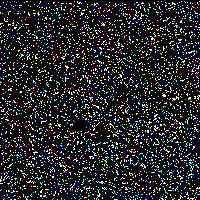

In [313]:
Image.fromarray(diff_between_images(mask_zones[0], mask_zones[1]))